In [1]:
import os
import tensorflow as tf

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import io
import numpy as np

In [3]:
import tensorflow_addons as tfa

In [4]:
def writeToFile(read_dir, write_dir, img):
    with open(os.path.join(read_dir, img), "rb") as r, \
        open(os.path.join(write_dir, img), "wb") as p:
        p.write(r.read())
        r.close()
        p.close()  

In [10]:
def preprocess(data_folder_path):
    processed_path = os.path.join(data_folder_path, 'lfw_processed')
    os.makedirs(processed_path, exist_ok=True)
    raw_path = os.path.join(data_folder_path, 'lfw_raw')
    first_dir=prev_dir=negative_sample=None

    # Loop through each directory of headshot images
    for directory in os.listdir(raw_path):
        if directory.startswith("."): continue
        path_to_raw_image_folder = os.path.join(raw_path, directory)
        images = os.listdir(path_to_raw_image_folder)

        # Only add directories which contain more than two headshots (needed for triplet loss)
        if len(images) >= 2:
            processed_img_path = os.path.join(processed_path, directory)
            os.makedirs(processed_img_path, exist_ok=True)

            # Cache first directory to add a negative sample after all loops
            if not first_dir: first_dir = path_to_raw_image_folder

            # Add negative sample
            #if negative_sample: writeToFile(prev_dir, processed_img_path, negative_sample)

            # Add each image to our processed folder structure and retain the last image as a negative sample
            # for future directory
            for img_file_name in images:

                writeToFile(path_to_raw_image_folder, processed_img_path, img_file_name)
                negative_sample = img_file_name

            prev_dir=path_to_raw_image_folder
   
    # Add a negative sample to the first headshot directory
    #writeToFile(prev_dir, first_dir, negative_sample)

In [11]:
preprocess('data_folder')

In [147]:
batch_size = 32
img_height = 250
img_width = 250
img_channels = 3

data_dir = 'data_folder/lfw_processed'

In [148]:
dev_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 9164 files belonging to 1680 classes.


In [149]:
@tf.autograph.experimental.do_not_convert
def _normalize_img(img, label):
    image = tf.cast(img/255. ,tf.float32)
    return image, label

In [150]:
dev_dataset = dev_ds.map(_normalize_img)

In [151]:
#No test/val split since pretraining

'''
train_split = 0.8
val_split = 0.2

ds_size = len(list(dev_dataset))
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)

train_ds = dev_dataset.take(train_size)    
val_ds = dev_dataset.skip(train_size).take(val_size)
'''

'\ntrain_split = 0.8\nval_split = 0.2\n\nds_size = len(list(dev_dataset))\ntrain_size = int(train_split * ds_size)\nval_size = int(val_split * ds_size)\n\ntrain_ds = dev_dataset.take(train_size)    \nval_ds = dev_dataset.skip(train_size).take(val_size)\n'

In [152]:
for image_batch, labels_batch in dev_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 250, 250, 3)
(32,)


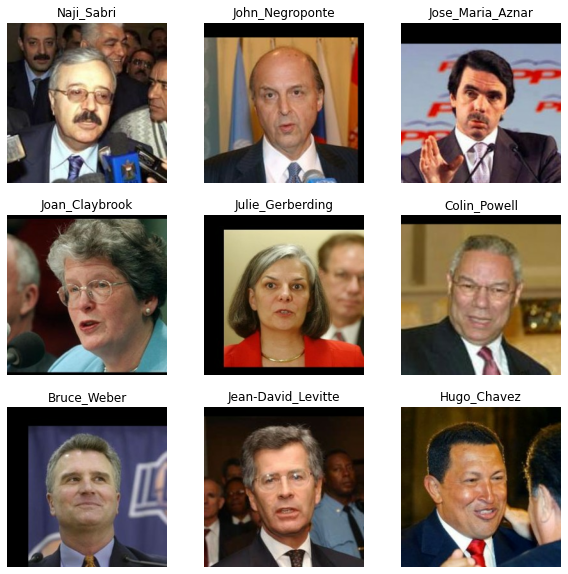

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dev_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [154]:
#Build DCNN model with Skip Connections

input_net = tf.keras.layers.Input((img_height, img_width, img_channels))
conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(input_net)
merge1 = tf.keras.layers.concatenate([input_net, conv1], axis = 3)
mpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)(merge1)
drop1 = tf.keras.layers.Dropout(0.2)(mpool1)
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(drop1)
merge2 = tf.keras.layers.concatenate([drop1,conv2], axis = 3)
mpool2 = tf.keras.layers.MaxPooling2D(pool_size=2)(merge2)
drop2 = tf.keras.layers.Dropout(0.2)(mpool2)
flat1 = tf.keras.layers.Flatten()(drop2)
fc1 = tf.keras.layers.Dense(256, activation=None)(flat1)
output_net = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(fc1)

model = tf.keras.models.Model(inputs = input_net, outputs = output_net)


In [155]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tfa.losses.TripletHardLoss())

In [156]:
# Train the network
@tf.autograph.experimental.do_not_convert
def train_model(model, epochs=5):
    history = model.fit(
        x=dev_dataset,
        epochs=epochs)
    return history

In [157]:
training_history = train_model(model, 20)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
287/287 [==============================] - 866s 3s/step - loss: 0.3925
Epoch 2/20
287/287 [==============================] - 896s 3s/step - loss: 0.1655
Epoch 3/20
287/287 [==============================] - 886s 3s/step - loss: 0.1639
Epoch 4/20
287/287 [==============================] - 839s 3s/step - loss: 0.1471
Epoch 5/20
287/287 [==============================

In [158]:
model.save('saved_model/pretrained_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

INFO:tensorflow:Assets written to: saved_model/pretrained_model\assets


INFO:tensorflow:Assets written to: saved_model/pretrained_model\assets


In [159]:
data_dir = 'data_folder/pubfig'

pubfig_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

pubfig_dataset = pubfig_ds.map(_normalize_img)

Found 11640 files belonging to 150 classes.


In [160]:
train_split = 0.6
val_split = 0.2
test_split = 0.2

ds_size = len(list(pubfig_dataset))
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)
test_size = int(test_split * ds_size)

train_ds = pubfig_dataset.take(train_size)    
val_ds = pubfig_dataset.skip(train_size).take(val_size)
test_ds = pubfig_dataset.skip(train_size + val_size).take(test_size)

In [161]:
history = model.fit(
        x=train_ds,
        epochs=20,
        validation_data=val_ds)

Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 0.3085WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000180DC2311E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
218/218 [==============================] - 698s 3s/step - loss: 0.3085 - val_loss: 0.3022
Epoch 2/20
218/218 [==============================] - 685s 3s/step - loss: 0.3117 - val_loss: 0.3030
Epoch 3/20
218/218 [==============================] - 687s 3s/step - loss: 0.2940 - val_loss: 0.2776
Epoch 4/20
218/218 [==============================] - 686s 3s/step - loss: 0.2964 - val_loss: 0.3168
Epoch 5/20
218/218 [==============================] - 686s 3s/step - loss: 0.2864 - val_loss: 0.3044
Epoch 6/20
218/218 [==============================] - 687s 3s/step - loss: 0.2892 - val_loss: 0.2808
Epoch 7/20
218/218 [==============================] - 686s 3s/step - loss: 0.2817 - val_loss: 

In [162]:
model.save('saved_model/tuned_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: saved_model/tuned_model\assets


INFO:tensorflow:Assets written to: saved_model/tuned_model\assets


In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:   
baseline_hist_df = pd.DataFrame(training_history.history) 
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'saved_model/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)